In [189]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# models
import xgboost as xgb
from sklearn import metrics
from sklearn.utils import resample
import scipy.stats as stats

# Abstract

##  - We used boostrapping and statistical tests to check convert rate and revenue per user;

##  - The price change introduces revenue by +10%. But since convert rate drop by -10%, we should produce a targeted price for different operating systems.

# Problem

Company XYZ sells a software package for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

hints
- Remember who your audience is here (a VP of product) they are likely not technical.
- How do you present your findings, how do you add context to your recommendation?
- Was the test well formulated?  How much time should it have been run to detect different effect sizes?
- Are there any holistic pieces of information that might change the idea that just upping the price is a good thing?

# Data

"test_results" - data about the test

Columns:
- user_id : the Id of the user. Can be joined to user_id in user_table
- timestamp : the date and time when the user hit for the first time company XYZ
- webpage. It is in user local time
- source : marketing channel that led to the user coming to the site. It can be:
    - ads ("google", "facebook", "bing", "yahoo", "other"). That is, user coming from google ads, yahoo ads, etc.
    - seo ("google", "facebook", "bing", "yahoo", "other"). That is, user coming from google search, yahoo, facebook, etc.
    - friend_referral : user coming from a referral link of another user
    - direct_traffic: user coming by directly typing the address of the site on the browser
- device : user device. Can be mobile or web
- operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above
- test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)
- price : the price the user sees. It should match test
- converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

"user_table" - Information about the user

Columns:
- user_id : the Id of the user. Can be joined to user_id in test_results table
- city : the city where the user is located. Comes from the user ip address
- country : in which country the city is located
- lat : city latitude - should match user city
- long : city longitude - should match user city

In [2]:
df_test_results = pd.read_csv("Data/test_results.csv", index_col=0)

## Clean data that have test doesn't match the price; 98.9% of data pass this requirement

In [3]:
df_test_results = df_test_results.loc[((df_test_results.test == 1) 
                     & (df_test_results.price == 59.0)) 
                    | ((df_test_results.test == 0) 
                       & (df_test_results.price == 39.0))]
#print(df_test_results.shape)

In [4]:
df_test_results.shape

(313363, 8)

## Merge with the user table data

In [5]:
df_user_table = pd.read_csv("Data/user_table.csv")

In [6]:
df_test_results = df_test_results.merge(
    df_user_table, on="user_id", how='left')

In [7]:
df_test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313363 entries, 0 to 313362
Data columns (total 12 columns):
user_id             313363 non-null int64
timestamp           313034 non-null object
source              313056 non-null object
device              313363 non-null object
operative_system    293276 non-null object
test                313363 non-null int64
price               313363 non-null float64
converted           313363 non-null int64
city                272621 non-null object
country             272621 non-null object
lat                 272621 non-null float64
long                272621 non-null float64
dtypes: float64(3), int64(3), object(6)
memory usage: 31.1+ MB


In [8]:
df_test_results.describe()

user_id           test          price      converted  \
count   313363.000000  313363.000000  313363.000000  313363.000000   
mean    499338.454339       0.359870      46.197404       0.018327   
std     288610.862428       0.479963       9.599258       0.134131   
min          3.000000       0.000000      39.000000       0.000000   
25%     249513.500000       0.000000      39.000000       0.000000   
50%     499216.000000       0.000000      39.000000       0.000000   
75%     749097.500000       1.000000      59.000000       0.000000   
max    1000000.000000       1.000000      59.000000       1.000000   

                 lat           long  
count  272621.000000  272621.000000  
mean       37.112807     -93.978109  
std         5.209647      18.087478  
min        19.700000    -157.800000  
25%        33.660000    -112.200000  
50%        37.740000     -88.930000  
75%        40.700000     -78.910000  
max        61.180000      30.310000

In [9]:
df_test_results.dropna().describe()

user_id           test          price      converted  \
count  254534.000000  254534.000000  254534.000000  254534.000000   
mean   499156.826950       0.358730      46.174601       0.018701   
std    288473.070843       0.479629       9.592574       0.135467   
min         3.000000       0.000000      39.000000       0.000000   
25%    249527.750000       0.000000      39.000000       0.000000   
50%    498796.500000       0.000000      39.000000       0.000000   
75%    748685.250000       1.000000      59.000000       0.000000   
max    999999.000000       1.000000      59.000000       1.000000   

                 lat           long  
count  254534.000000  254534.000000  
mean       37.107995     -93.982034  
std         5.210622      18.056394  
min        19.700000    -157.800000  
25%        33.660000    -112.200000  
50%        37.720000     -88.930000  
75%        40.700000     -79.040000  
max        61.180000      30.310000

## Missing data are operating system, or user location. They have same distribution as the complete data.

## Need to rename the operating system to correct typo

In [10]:
df_test_results.operative_system = df_test_results.operative_system.apply(lambda x: 'iOS' if x == 'i0S' else x)
df_test_results.operative_system = df_test_results.operative_system.apply(lambda x: 'windows' if x == 'wnddows' else x)
df_test_results.operative_system = df_test_results.operative_system.apply(lambda x: 'android' if x == 'anroid' else x)
df_test_results.operative_system = df_test_results.operative_system.apply(lambda x: 'mac' if x == 'apple' else x)

In [180]:
## Need to rename the source
df_test_results.source = df_test_results.source.apply(lambda x: 'ads' if 'ads' in str(x) else x)
df_test_results.source = df_test_results.source.apply(lambda x: 'seo' if 'seo' in str(x) else x)
df_test_results.source = df_test_results.source.apply(lambda x: 'direct' if 'direct' in str(x) else x)
df_test_results.source = df_test_results.source.apply(lambda x: 'friend' if 'friend' in str(x) else x)

# EDA

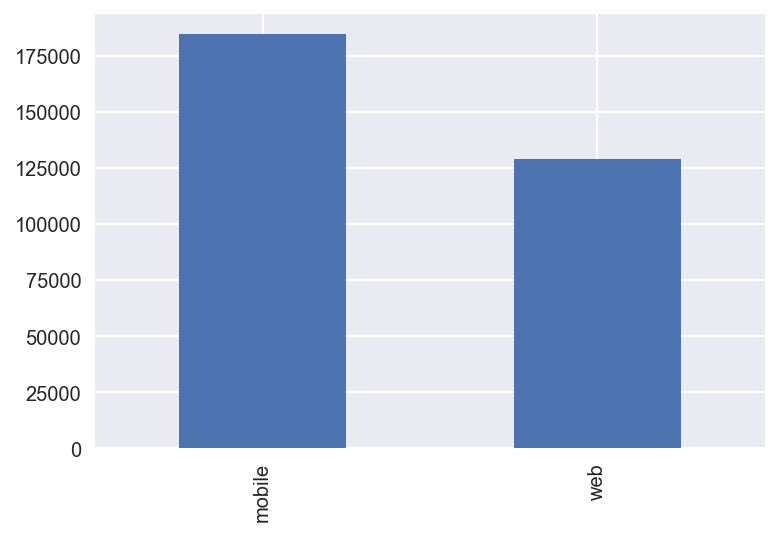

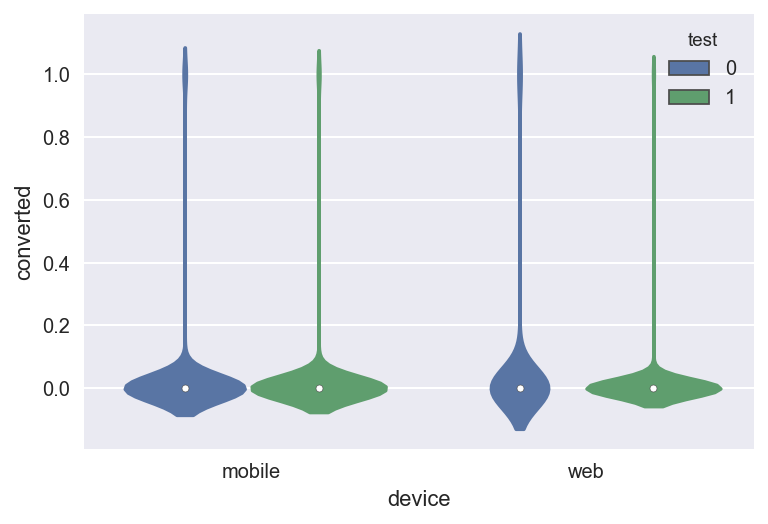

In [262]:
df_test_results.device.value_counts().plot(kind='bar')
plt.show()
sns.violinplot(x="device", y="converted", hue="test", data=df_test_results[:1000])
plt.show()

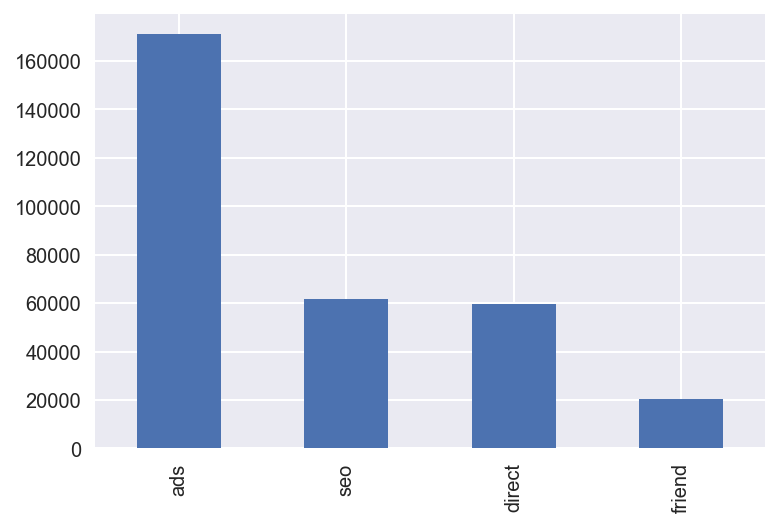

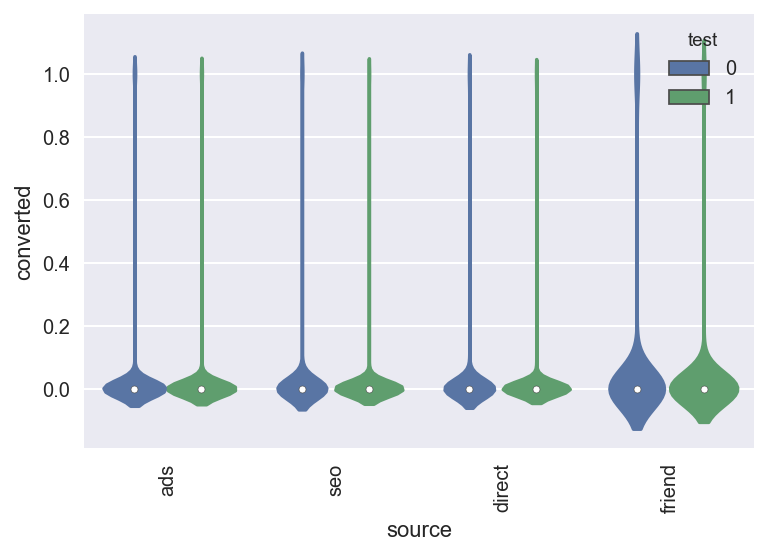

In [263]:
df_test_results.source.value_counts().plot(kind='bar')
plt.show()
sns.violinplot(x="source", y="converted", hue="test", data=df_test_results[:10000])
plt.xticks(rotation='vertical')
plt.show()

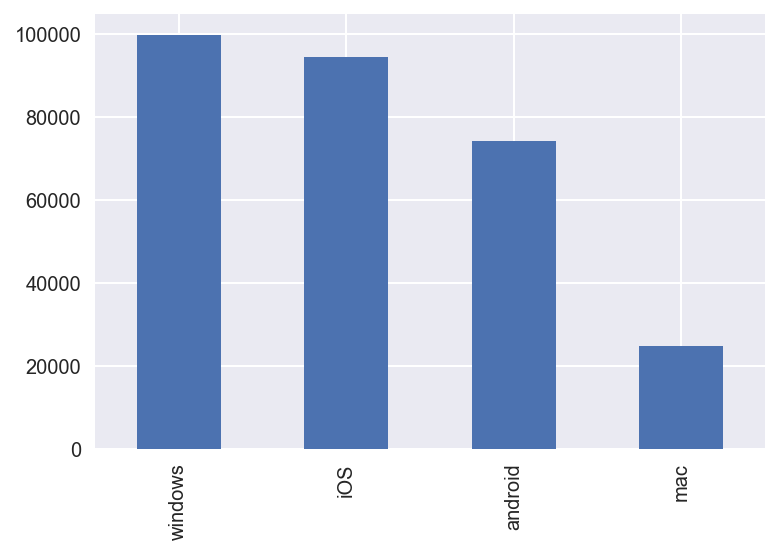

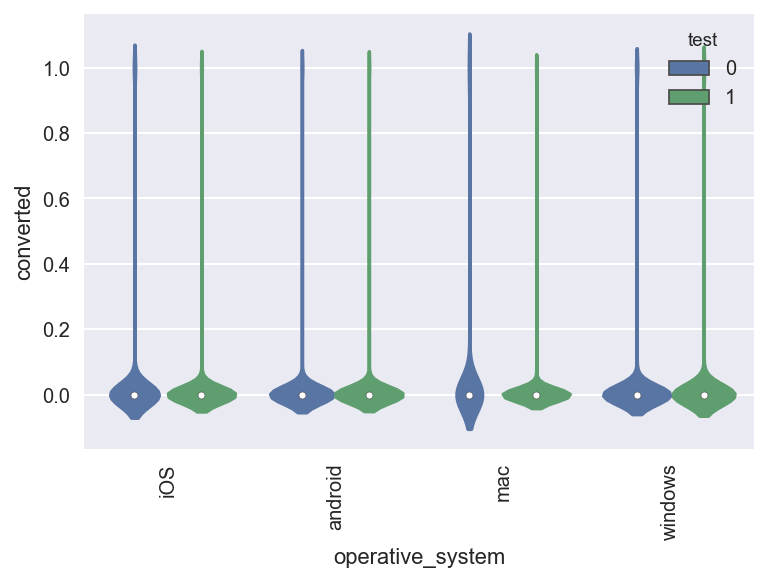

In [264]:
df_test_results.operative_system.value_counts().plot(kind='bar')
plt.show()
sns.violinplot(x="operative_system", y="converted", hue="test", data=df_test_results[:10000])
plt.xticks(rotation='vertical')
plt.show()

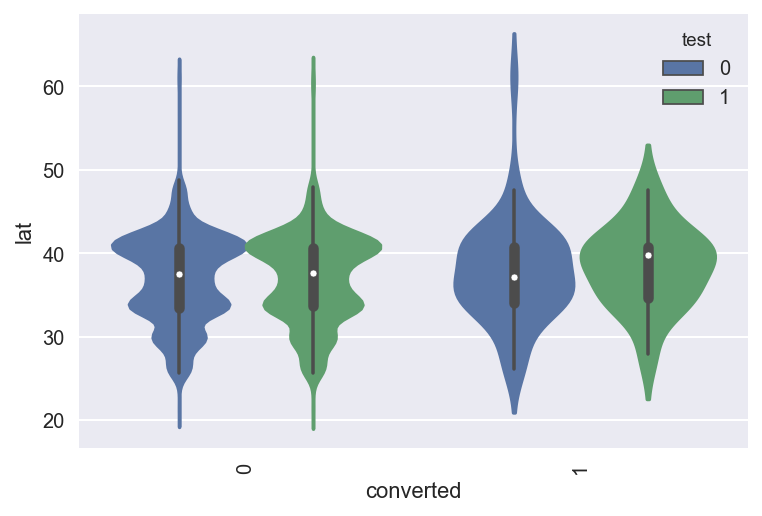

In [122]:
sns.violinplot(x="converted", y="lat", hue="test", data=df_test_results[:5000])
plt.xticks(rotation='vertical')
plt.show()

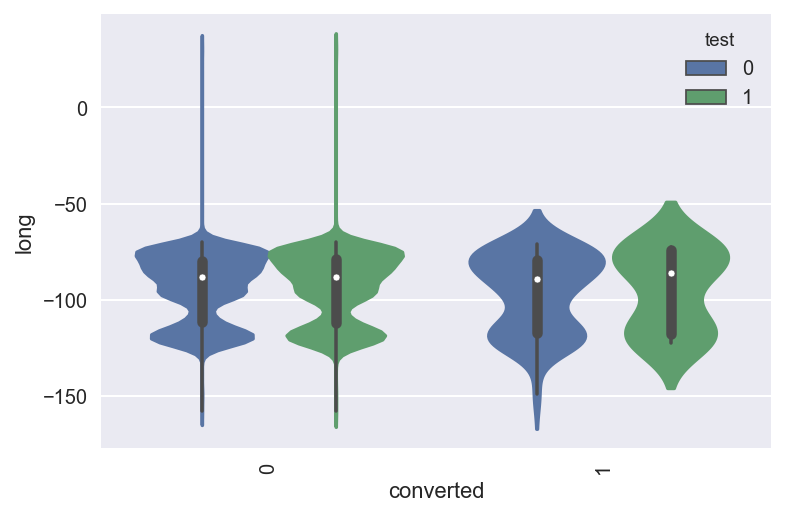

In [121]:
sns.violinplot(x="converted", y="long", hue="test", data=df_test_results[:5000])
plt.xticks(rotation='vertical')
plt.show()

In [255]:
# df_test_results.loc[(df_test_results.test == 1) 
#                     & (df_test_results.converted == 0)].groupby('city').count().nlargest(10, 'user_id')

In [256]:
# df_test_results.loc[(df_test_results.test == 1) 
#                     & (df_test_results.converted == 1)].groupby('city').count().nlargest(10, 'user_id')

# Model

## Key Metric: user revenue -- given a user, 59 makes more profit or not

## Two hypothesis tests: is conversion rate drop by 10%, and profit raise by 10%
## Statistic alpha chosen to be 0.003, ~ 3 sigma

In [245]:
def keymetrictest(df_test0, df_test1, title="all"):
    ## setup bootstrap
    n_iter   = 500
    #given conversion rate is ~ 0.02, need at least 10000 to be significant
    #bootstrap half of the data for now
    n_samples = int(min(df_test0.shape[0], df_test1.shape[0]) * 0.5)
    mean_test0 = []
    mean_test1 = []

    ## boostrap and set the random seed
    for i in tqdm(range(n_iter)):
        mean_test0.append(resample(df_test0.converted, n_samples=n_samples, random_state=i).mean())
        mean_test1.append(resample(df_test1.converted, n_samples=n_samples, random_state=i).mean())

    mean_test0 = np.array(mean_test0)
    mean_test1 = np.array(mean_test1)

    # confidence intervals for rates
    alpha = 0.95
    p_l = ((1.0-alpha)/2.0) * 100
    p_u = (alpha+((1.0-alpha)/2.0)) * 100
    

    test_0lower = max(0.0, np.percentile(mean_test0, p_l))
    test_0upper = min(1.0, np.percentile(mean_test0, p_u))
    print('Low  price convert rate: %.3f%% mean 95 CI:[%.3f%%, %.3f%%]' 
          % (mean_test0.mean()*100, test_0lower*100, test_0upper*100))
    test_1lower = max(0.0, np.percentile(mean_test1, p_l))
    test_1upper = min(1.0, np.percentile(mean_test1, p_u))
    print('High price convert rate: %.3f%% mean 95 CI:[%.3f%%, %.3f%%]' 
          % (mean_test1.mean()*100, test_1lower*100, test_1upper*100))
    test_diff = (mean_test1 - mean_test0)/(mean_test0)
    test_difflower = np.percentile(test_diff, p_l)
    test_diffupper = np.percentile(test_diff, p_u)
    print('Convert rate diff: %.3f %% 95 CI: [%.3f, %.3f]' % 
          (test_diff.mean() * 100, 
           test_difflower * 100, test_diffupper* 100))
    
    ## Hypothesis test
    ## NULL test0 has converion rate > test1
    ## statistic is alpha=0.003
    test_alpha = 0.003
    test_t, test_p = stats.ttest_ind(mean_test0, mean_test1 + mean_test0.mean() * 0.1, equal_var=True)
    if (test_t > 0 and test_p/2 < test_alpha):
        print('T-test convert rate: lowprice > highprice')
    elif (test_t < 0 and test_p/2 < test_alpha):
        print('T-test convert rate: lowprice < highprice')
    else:
        print('T-test convert rate: inconclusive, p %.3f' % test_p)
        
    plt.clf()
    min_rate = min(np.concatenate((mean_test0, mean_test1), axis=None)) * 0.9
    max_rate = max(np.concatenate((mean_test0, mean_test1), axis=None)) * 1.1
    plt.hist(mean_test0, label="$39", alpha=0.7, bins=np.linspace(min_rate, max_rate, 50))
    plt.hist(mean_test1, label="$59", alpha=0.7, bins=np.linspace(min_rate, max_rate, 50))
    plt.xlabel("convert rate")
    plt.ylabel("bootstrap counts")
    plt.title(title)
    plt.legend()
    plt.show()

    ##check revenue
    revenue_test0 = np.array(mean_test0) * 39
    revenue_test1 = np.array(mean_test1) * 59
    
    
    testr_0lower = max(0.0, np.percentile(revenue_test0, p_l))
    testr_0upper = min(10.0, np.percentile(revenue_test0, p_u))
    print('Low  price revenue: %.3f mean 95 CI: [%.3f %.3f]' 
          % (revenue_test0.mean(), testr_0lower, testr_0upper))
    testr_1lower = max(0.0, np.percentile(revenue_test1, p_l))
    testr_1upper = min(10.0, np.percentile(revenue_test1, p_u))
    print('High price revenue: %.3f mean 95 CI: [%.3f, %.3f]' 
          % (revenue_test1.mean(), testr_1lower, testr_1upper))
    testr_diff = (revenue_test1 - revenue_test0)/revenue_test0
    testr_difflower = np.percentile(testr_diff, p_l)
    testr_diffupper = np.percentile(testr_diff, p_u)
    print('Revenue diff: %.3f %% 95 CI: [%.3f, %.3f]' % 
          (testr_diff.mean() * 100, 
          testr_difflower * 100, testr_diffupper * 100))
    
    ## Hypothesis test
    ## NULL test0 has revenue > test1
    revenue_t, revenue_p = stats.ttest_ind(revenue_test0, revenue_test1 - revenue_test0.mean() * 0.1, equal_var=True)
    if (revenue_t > 0 and revenue_p/2 < test_alpha):
        print('T-test revenue: lowprice > highprice')
    elif (revenue_t < 0 and revenue_p/2 < test_alpha):
        print('T-test revenue: lowprice < highprice')
    else:
        print('T-test revenue: inconclusive, p %.3f' % revenue_p)
    
    
    plt.clf()
    min_rev = min(np.concatenate((revenue_test0, revenue_test1), axis=None)) * 0.9
    max_rev = max(np.concatenate((revenue_test0, revenue_test1), axis=None)) * 1.1
    plt.hist(revenue_test0, label="$39", alpha=0.7, bins=np.linspace(min_rev, max_rev, 50))
    plt.hist(revenue_test1, label="$59", alpha=0.7, bins=np.linspace(min_rev, max_rev, 50))
    plt.title(title)
    plt.xlabel("revenue")
    plt.ylabel("bootstrap counts")
    plt.legend()
    plt.show()
    

100%|██████████| 500/500 [00:01<00:00, 389.32it/s]


Low  price convert rate: 1.989% mean 95 CI:[1.876%, 2.107%]
High price convert rate: 1.553% mean 95 CI:[1.449%, 1.657%]
Convert rate diff: -21.876 % 95 CI: [-28.113, -14.768]
T-test convert rate: lowprice > highprice


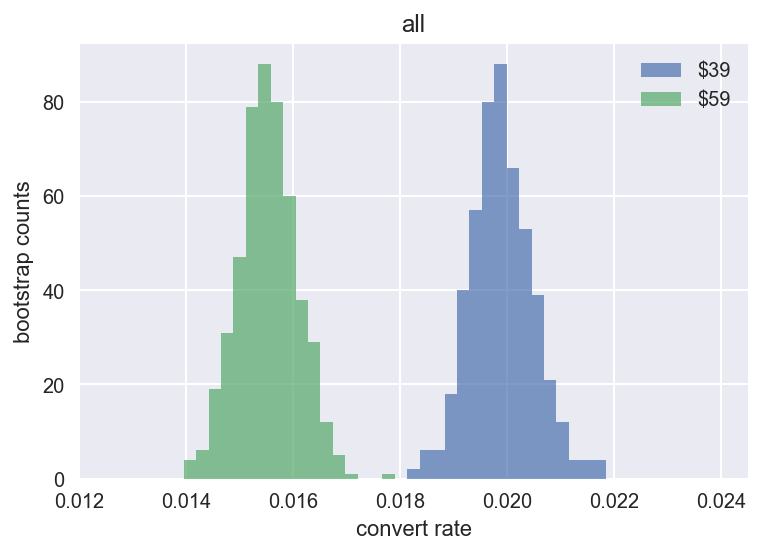

Low  price revenue: 0.776 mean 95 CI: [0.732 0.822]
High price revenue: 0.916 mean 95 CI: [0.855, 0.978]
Revenue diff: 18.188 % 95 CI: [8.752, 28.940]
T-test revenue: lowprice < highprice


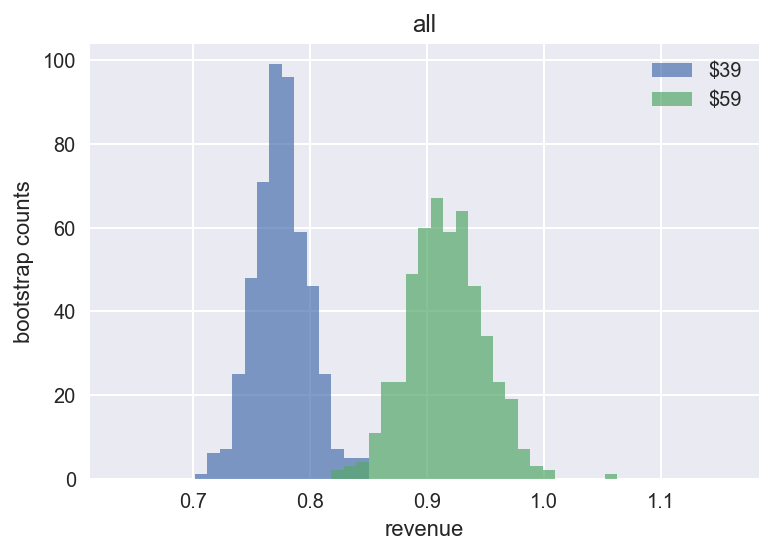

In [246]:
df_all0 = df_test_results.loc[df_test_results.test == 0]
df_all1 = df_test_results.loc[df_test_results.test == 1]
keymetrictest(df_all0, df_all1)

### High price makes significantly lower convert rate: down by 0.4, or -21% original convert rate
### High price makes significantly more revenue: up by 0.14 USD, or +18% original convert rate

100%|██████████| 500/500 [00:00<00:00, 940.33it/s]


Low  price convert rate: 2.346% mean 95 CI:[2.132%, 2.611%]
High price convert rate: 1.998% mean 95 CI:[1.783%, 2.192%]
Convert rate diff: -14.586 % 95 CI: [-27.062, -3.242]
T-test convert rate: lowprice > highprice


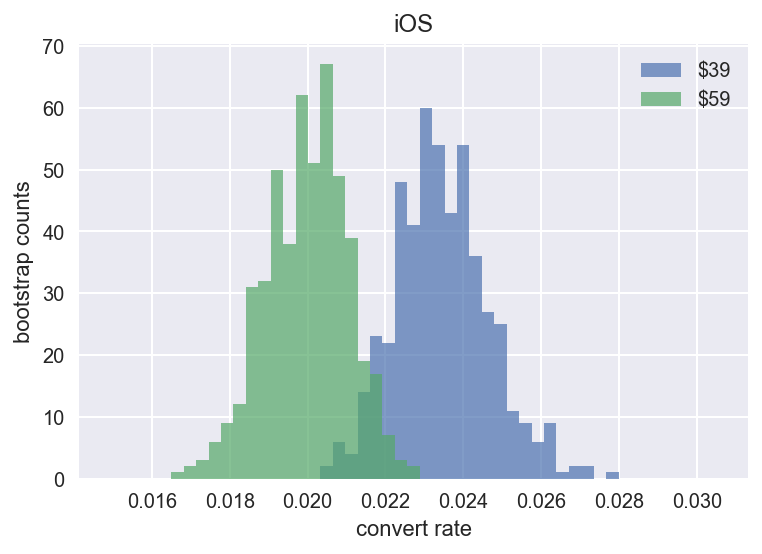

Low  price revenue: 0.915 mean 95 CI: [0.831 1.018]
High price revenue: 1.179 mean 95 CI: [1.052, 1.293]
Revenue diff: 29.216 % 95 CI: [10.342, 46.378]
T-test revenue: lowprice < highprice


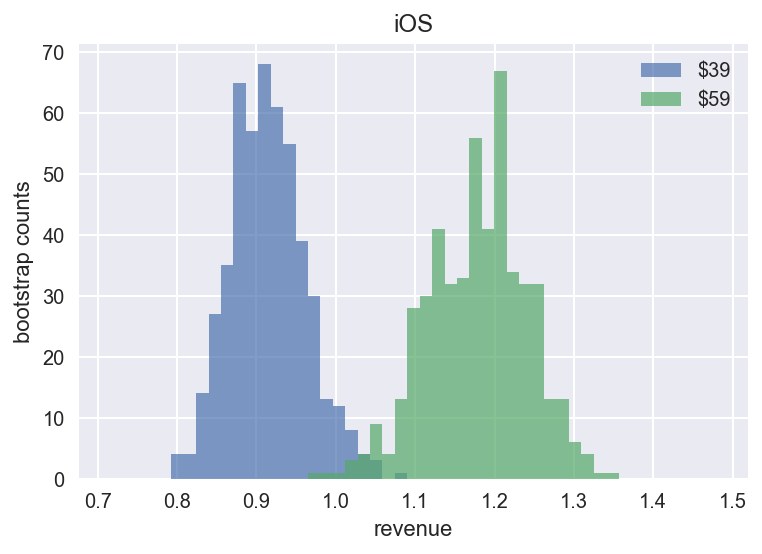

100%|██████████| 500/500 [00:00<00:00, 1211.89it/s]


Low  price convert rate: 1.636% mean 95 CI:[1.433%, 1.842%]
High price convert rate: 1.239% mean 95 CI:[1.059%, 1.426%]
Convert rate diff: -23.921 % 95 CI: [-38.168, -7.036]
T-test convert rate: lowprice > highprice


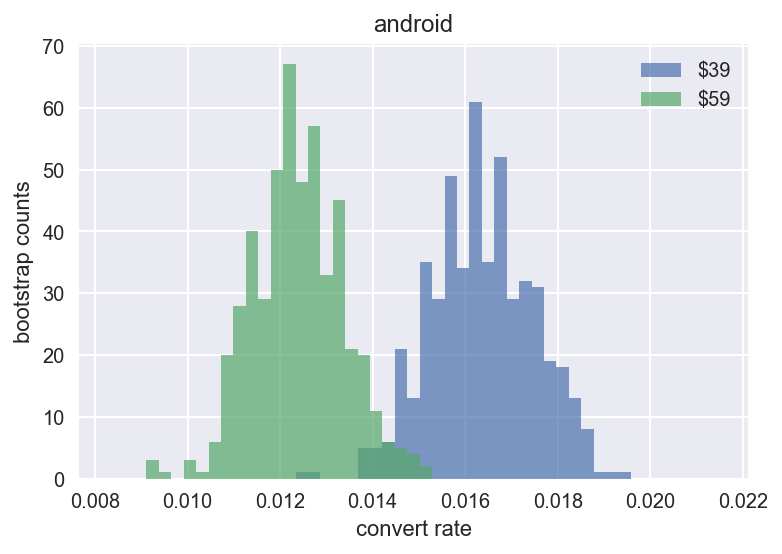

Low  price revenue: 0.638 mean 95 CI: [0.559 0.718]
High price revenue: 0.731 mean 95 CI: [0.625, 0.841]
Revenue diff: 15.094 % 95 CI: [-6.459, 40.637]
T-test revenue: lowprice < highprice


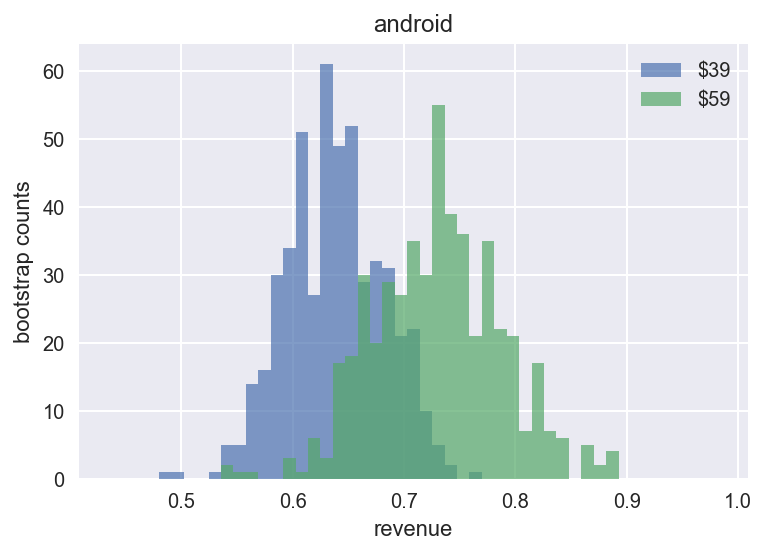

100%|██████████| 500/500 [00:00<00:00, 899.80it/s]


Low  price convert rate: 1.875% mean 95 CI:[1.677%, 2.067%]
High price convert rate: 1.397% mean 95 CI:[1.239%, 1.564%]
Convert rate diff: -25.264 % 95 CI: [-35.526, -12.846]
T-test convert rate: lowprice > highprice


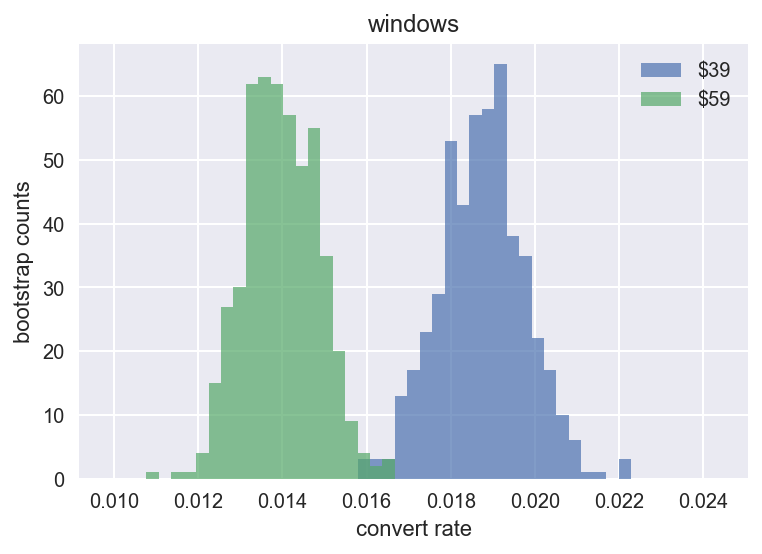

Low  price revenue: 0.731 mean 95 CI: [0.654 0.806]
High price revenue: 0.824 mean 95 CI: [0.731, 0.923]
Revenue diff: 13.062 % 95 CI: [-2.463, 31.848]
T-test revenue: lowprice < highprice


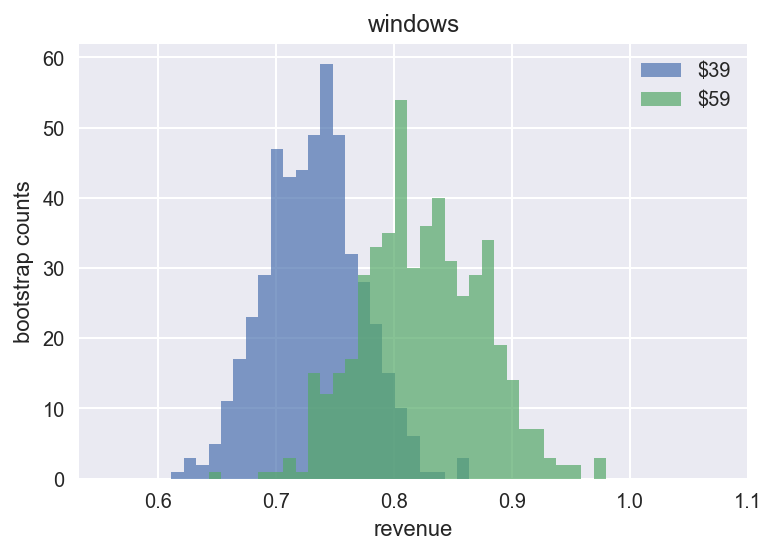

100%|██████████| 500/500 [00:00<00:00, 2104.23it/s]


Low  price convert rate: 2.561% mean 95 CI:[2.065%, 3.016%]
High price convert rate: 2.102% mean 95 CI:[1.694%, 2.506%]
Convert rate diff: -17.148 % 95 CI: [-38.235, 8.066]
T-test convert rate: lowprice > highprice


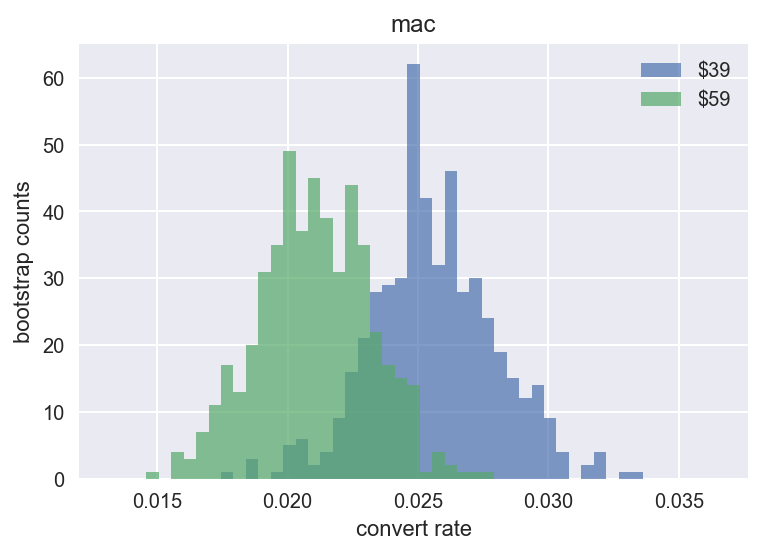

Low  price revenue: 0.999 mean 95 CI: [0.805 1.176]
High price revenue: 1.240 mean 95 CI: [0.999, 1.478]
Revenue diff: 25.340 % 95 CI: [-6.561, 63.484]
T-test revenue: lowprice < highprice


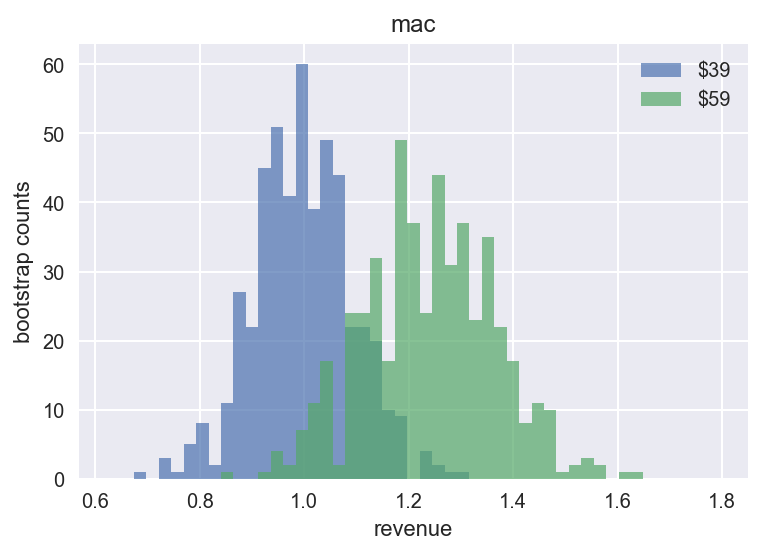

In [247]:
for name in ["iOS", "android", "windows", "mac"]:
    df_all0 = df_test_results.loc[(df_test_results.test == 0) & (df_test_results.operative_system == name)]
    df_all1 = df_test_results.loc[(df_test_results.test == 1) & (df_test_results.operative_system == name)]
    keymetrictest(df_all0, df_all1, title=name)

### result highly depends on the operating system; apple users tend to generate more significant revenue;

100%|██████████| 500/500 [00:00<00:00, 719.90it/s]


Low  price convert rate: 1.986% mean 95 CI:[1.832%, 2.149%]
High price convert rate: 1.619% mean 95 CI:[1.487%, 1.754%]
Convert rate diff: -18.353 % 95 CI: [-26.866, -9.440]
T-test convert rate: lowprice > highprice


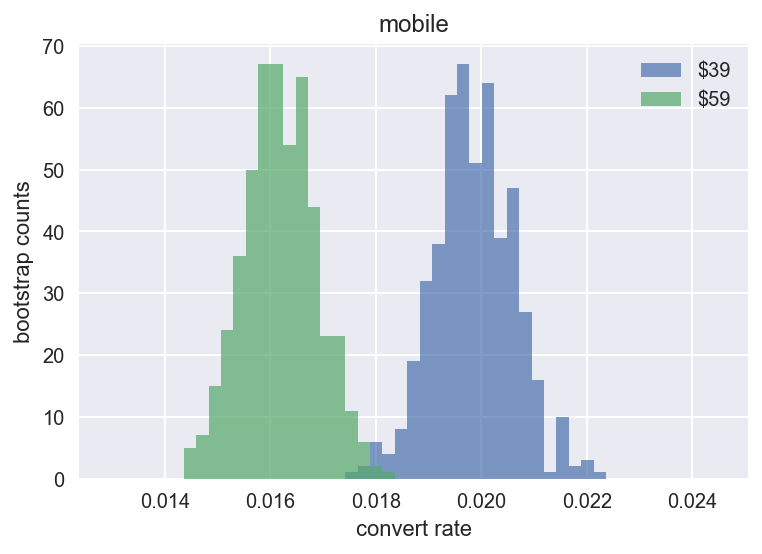

Low  price revenue: 0.774 mean 95 CI: [0.714 0.838]
High price revenue: 0.955 mean 95 CI: [0.877, 1.035]
Revenue diff: 23.517 % 95 CI: [10.639, 37.001]
T-test revenue: lowprice < highprice


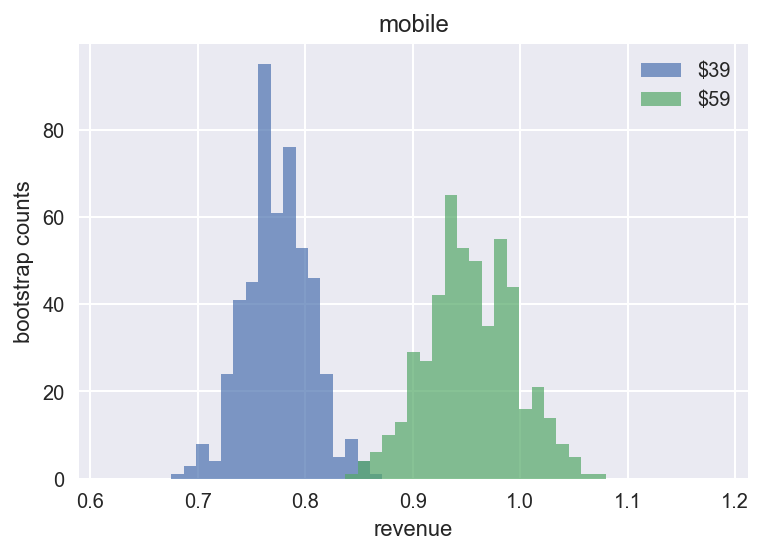

100%|██████████| 500/500 [00:00<00:00, 695.14it/s]


Low  price convert rate: 2.003% mean 95 CI:[1.819%, 2.183%]
High price convert rate: 1.467% mean 95 CI:[1.319%, 1.624%]
Convert rate diff: -26.613 % 95 CI: [-36.812, -16.199]
T-test convert rate: lowprice > highprice


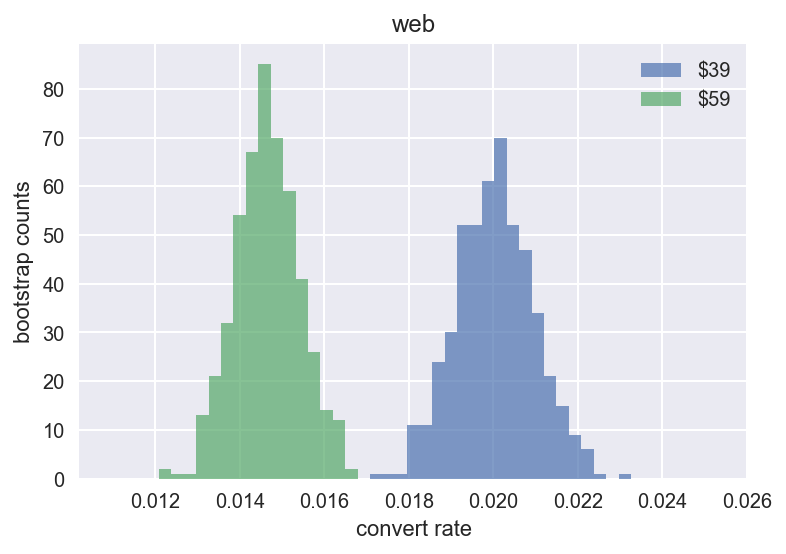

Low  price revenue: 0.781 mean 95 CI: [0.710 0.851]
High price revenue: 0.865 mean 95 CI: [0.778, 0.958]
Revenue diff: 11.022 % 95 CI: [-4.408, 26.776]
T-test revenue: inconclusive, p 0.019


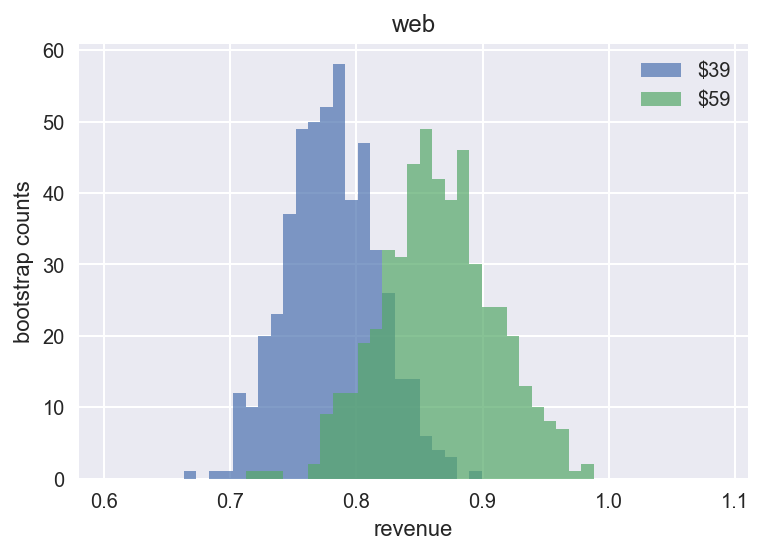

In [248]:
for name in ["mobile", "web"]:
    df_all0 = df_test_results.loc[(df_test_results.test == 0) & (df_test_results.device == name)]
    df_all1 = df_test_results.loc[(df_test_results.test == 1) & (df_test_results.device == name)]
    keymetrictest(df_all0, df_all1, title=name)

### result highly dependent on the device; revenue gain is obvious on mobile device but not so significant on web; 

100%|██████████| 500/500 [00:00<00:00, 709.62it/s]


Low  price convert rate: 2.022% mean 95 CI:[1.879%, 2.192%]
High price convert rate: 1.586% mean 95 CI:[1.462%, 1.722%]
Convert rate diff: -21.451 % 95 CI: [-29.550, -12.447]
T-test convert rate: lowprice > highprice


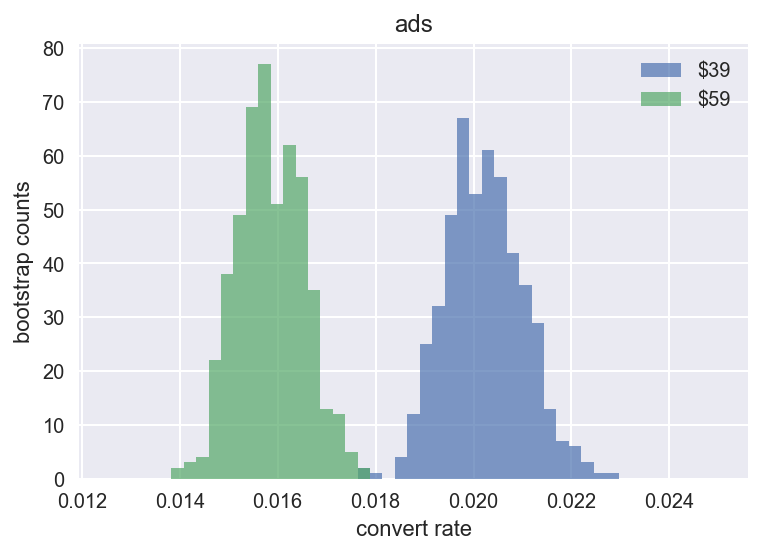

Low  price revenue: 0.788 mean 95 CI: [0.733 0.855]
High price revenue: 0.936 mean 95 CI: [0.863, 1.016]
Revenue diff: 18.831 % 95 CI: [6.578, 32.453]
T-test revenue: lowprice < highprice


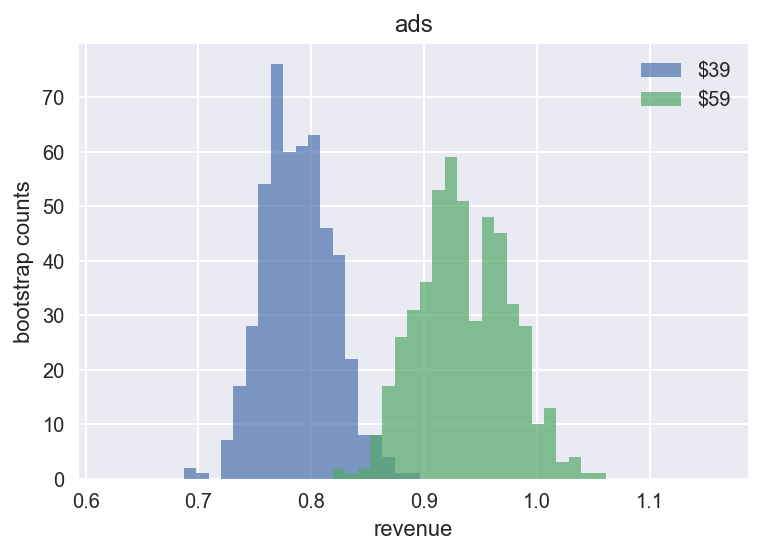

100%|██████████| 500/500 [00:00<00:00, 1204.34it/s]


Low  price convert rate: 1.799% mean 95 CI:[1.549%, 2.058%]
High price convert rate: 1.395% mean 95 CI:[1.216%, 1.608%]
Convert rate diff: -22.056 % 95 CI: [-35.824, -4.616]
T-test convert rate: lowprice > highprice


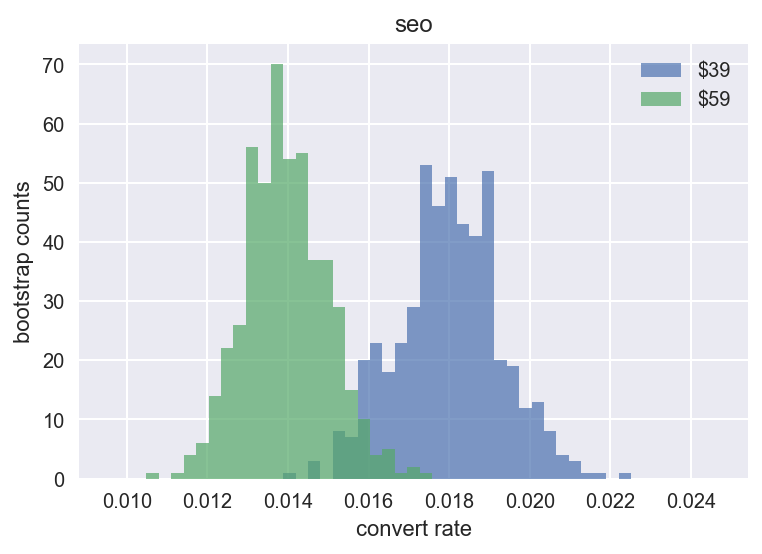

Low  price revenue: 0.702 mean 95 CI: [0.604 0.803]
High price revenue: 0.823 mean 95 CI: [0.717, 0.948]
Revenue diff: 17.915 % 95 CI: [-2.912, 44.298]
T-test revenue: lowprice < highprice


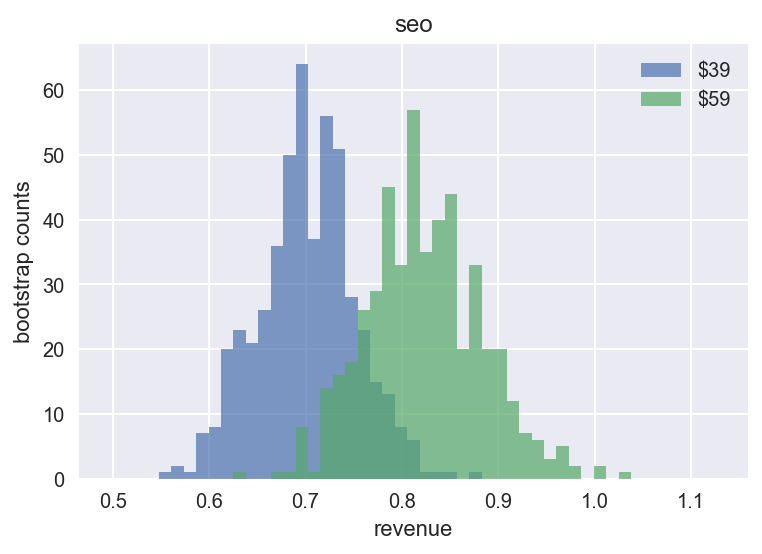

100%|██████████| 500/500 [00:00<00:00, 1226.23it/s]


Low  price convert rate: 1.366% mean 95 CI:[1.153%, 1.599%]
High price convert rate: 1.016% mean 95 CI:[0.834%, 1.200%]
Convert rate diff: -25.117 % 95 CI: [-42.153, -6.528]
T-test convert rate: lowprice > highprice


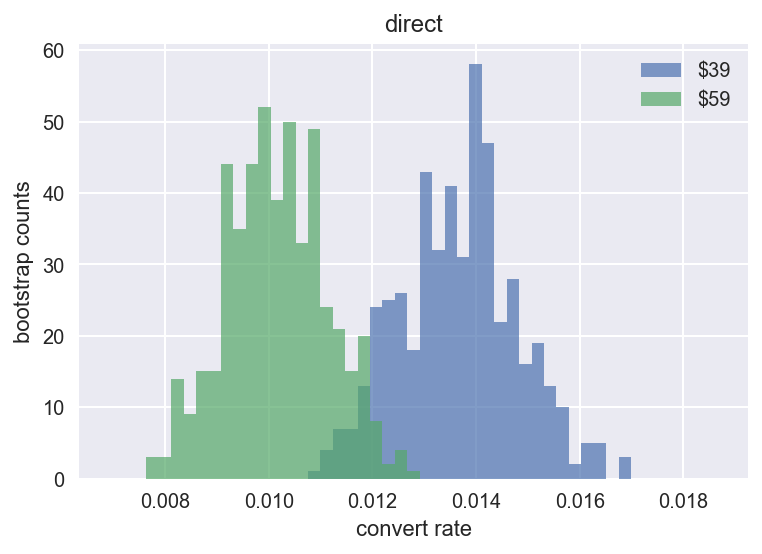

Low  price revenue: 0.533 mean 95 CI: [0.450 0.624]
High price revenue: 0.599 mean 95 CI: [0.492, 0.708]
Revenue diff: 13.284 % 95 CI: [-12.488, 41.407]
T-test revenue: lowprice < highprice


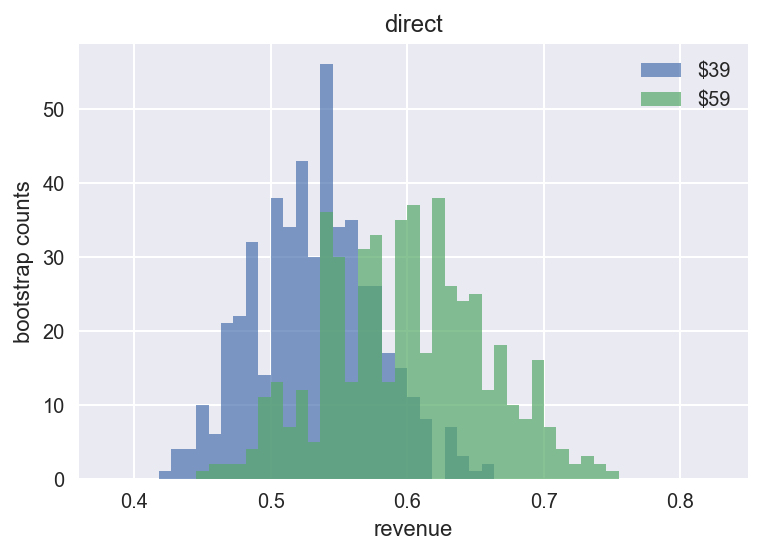

100%|██████████| 500/500 [00:00<00:00, 2270.25it/s]


Low  price convert rate: 4.179% mean 95 CI:[3.566%, 4.862%]
High price convert rate: 3.335% mean 95 CI:[2.752%, 3.901%]
Convert rate diff: -19.696 % 95 CI: [-36.364, 0.000]
T-test convert rate: lowprice > highprice


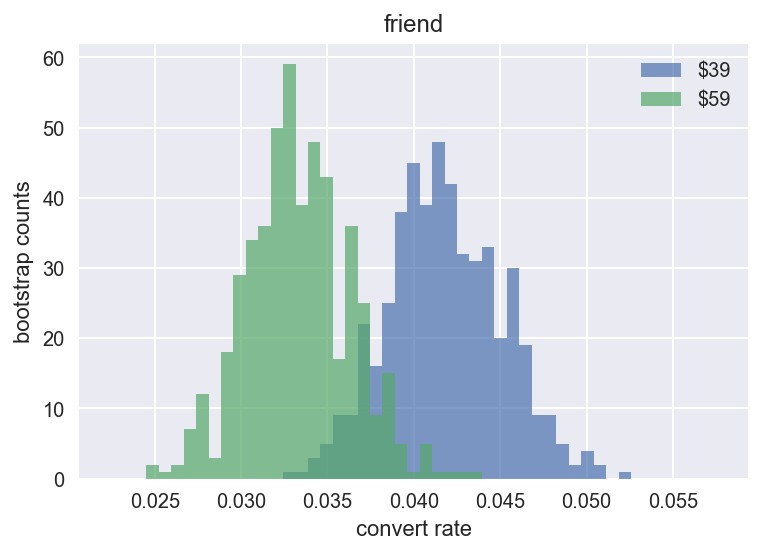

Low  price revenue: 1.630 mean 95 CI: [1.391 1.896]
High price revenue: 1.968 mean 95 CI: [1.624, 2.301]
Revenue diff: 21.485 % 95 CI: [-3.730, 51.282]
T-test revenue: lowprice < highprice


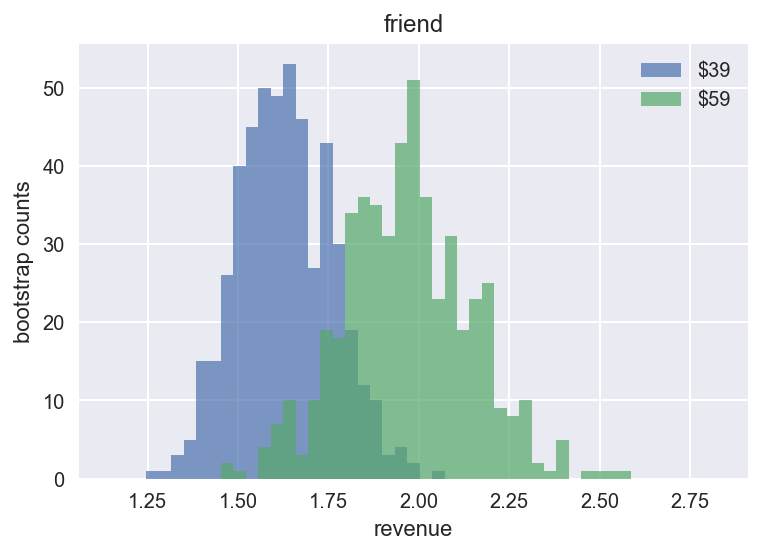

In [249]:
for name in df_test_results.source.unique():
    if type(name) != str:
        continue
    df_all0 = df_test_results.loc[(df_test_results.test == 0) & (df_test_results.source == name)]
    df_all1 = df_test_results.loc[(df_test_results.test == 1) & (df_test_results.source == name)]
    keymetrictest(df_all0, df_all1, title=name)

### result also depends on source; from ads it is clear, from search the revenue is no longer as separated, from direct the high price is no longer significant, same for from friend;

# Summary

##  - This price change introduces revenue by +10%. However, study shows the revenue tends to be more significant from mobile, apple users, and from advertisement.  

##  - Since there is a significant drop of convert rate by -10% in most cases, considering the market saturation, I would be suggest against rolling out this features on all users.  Instead, we should produce a targeted price for different operating systems.

# Future

##  - I would produce a operating system specific pricing-strategy based on this study.
##  - I would also check geographic information.
##  - Please give me more money, time, and data scientists.